In [23]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [24]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
record = wfdb.rdrecord('100', pn_dir='mitdb')
wfdb.plot_wfdb(record=record, title='ECG Signal')

Signal shape: (650000,), Sampling Rate: 360 Hz


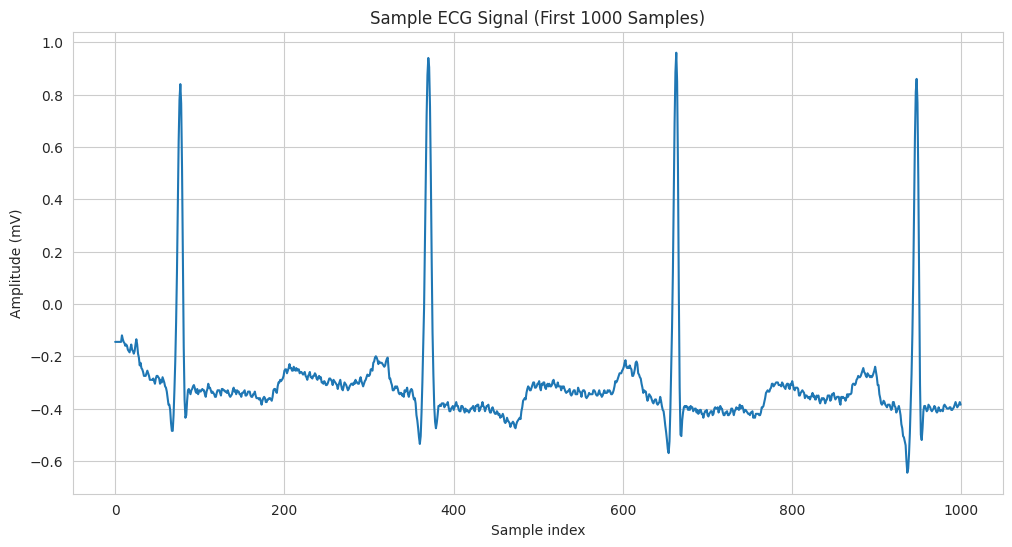

In [2]:
record = wfdb.rdrecord('100', pn_dir='mitdb')
signal = record.p_signal[:,0]
fs = record.fs
print(f"Signal shape: {signal.shape}, Sampling Rate: {fs} Hz")

plt.plot(signal[:1000])
plt.title("Sample ECG Signal (First 1000 Samples)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude (mV)")
plt.show()

Total segments: (2539, 256)


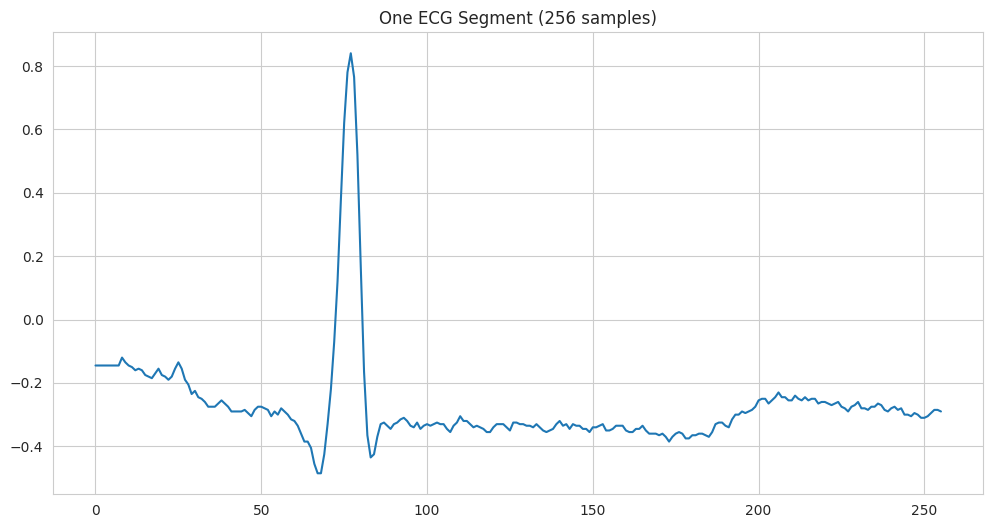

In [3]:
WINDOW_SIZE = 256
segments = []
for start in range(0, len(signal)-WINDOW_SIZE, WINDOW_SIZE):
    segment = signal[start:start+WINDOW_SIZE]
    segments.append(segment)
segments = np.array(segments)
print("Total segments:", segments.shape)

plt.plot(segments[0])
plt.title("One ECG Segment (256 samples)")
plt.show()

In [4]:
eda_df = pd.DataFrame({
    "mean": [np.mean(x) for x in segments],
    "std": [np.std(x) for x in segments],
    "max": [np.max(x) for x in segments],
    "min": [np.min(x) for x in segments],
    "range": [np.ptp(x) for x in segments]
})
display(eda_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
mean,2539.0,-0.306308,0.052422,-0.528750,-0.339014,-0.304473,-0.272402,0.017988
std,2539.0,0.180237,0.045628,0.020644,0.171361,0.187132,0.203557,0.528854
max,2539.0,0.879017,0.352217,-0.315000,0.855000,0.955000,1.067500,1.435000
min,2539.0,-0.550709,0.075948,-2.715000,-0.590000,-0.550000,-0.515000,-0.255000
range,2539.0,1.429726,0.372141,0.155000,1.430000,1.520000,1.610000,3.675000


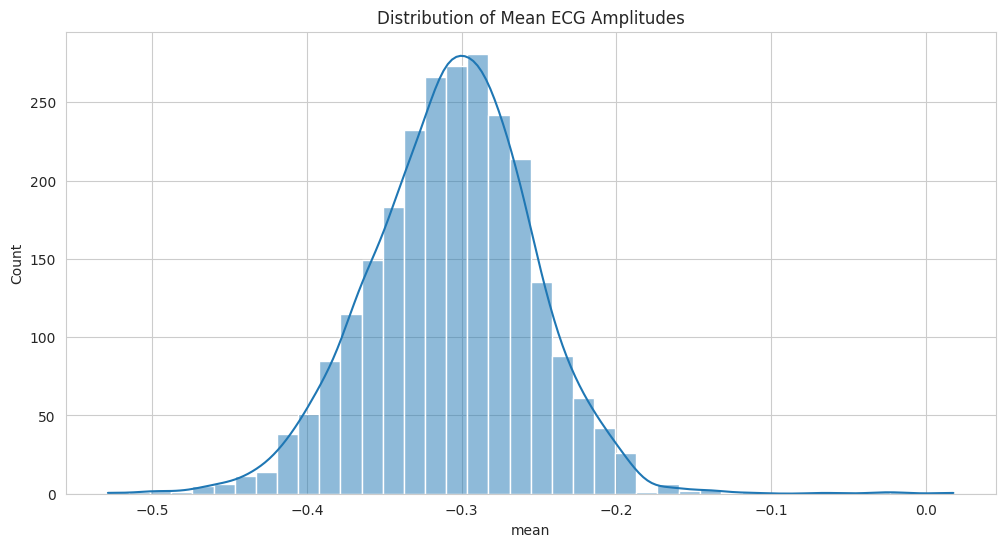

In [5]:
sns.histplot(eda_df["mean"], bins=40, kde=True)
plt.title("Distribution of Mean ECG Amplitudes")
plt.show()

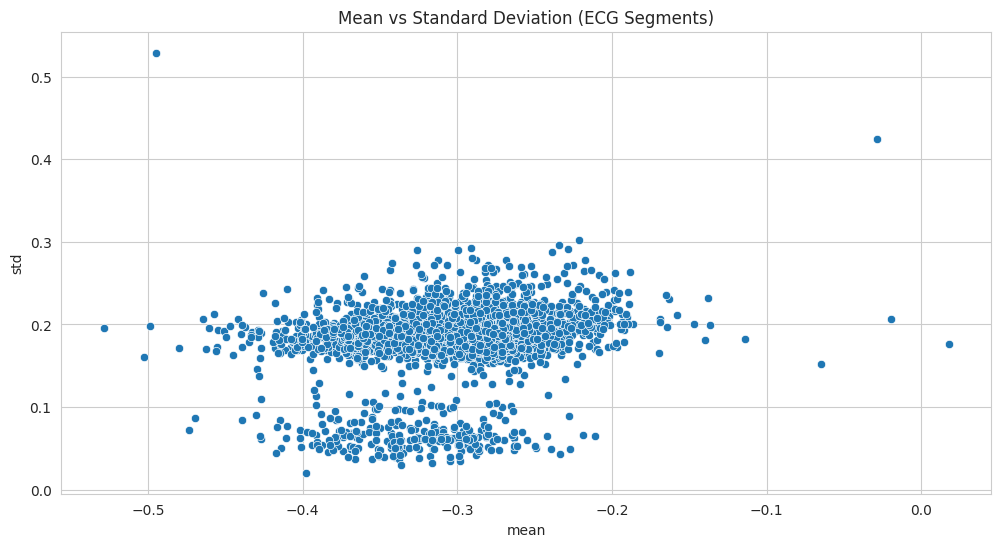

In [6]:
sns.scatterplot(x="mean", y="std", data=eda_df)
plt.title("Mean vs Standard Deviation (ECG Segments)")
plt.show()

In [8]:
# Normalize
data_norm = np.array([(x - np.mean(x)) / (np.std(x) + 1e-6) for x in segments])

class ECGDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx]
        return torch.tensor(x, dtype=torch.float32)

train_loader = DataLoader(ECGDataset(data_norm), batch_size=64, shuffle=True)
print(f"Total samples: {len(data_norm)}")

Total samples: 2539


In [9]:
class ECGAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

In [10]:
input_dim = data_norm.shape[1]
model = ECGAutoencoder(input_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

ECGAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
  )
)


Epoch 00/30 | Loss: 0.893036
Epoch 05/30 | Loss: 0.117958
Epoch 10/30 | Loss: 0.062101
Epoch 15/30 | Loss: 0.045460
Epoch 20/30 | Loss: 0.037960
Epoch 25/30 | Loss: 0.033823


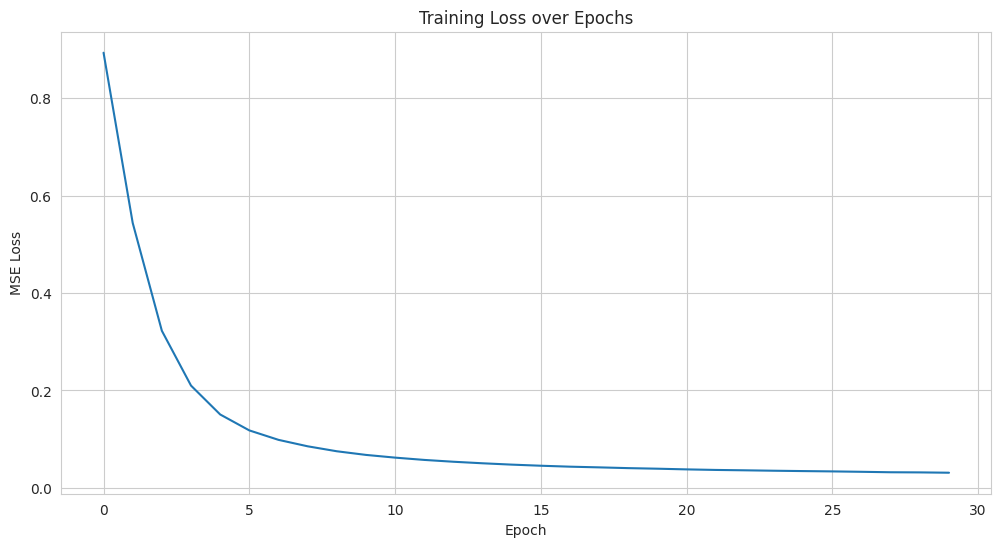

In [11]:
# Training Loop
EPOCHS = 30
losses = []

for epoch in range(EPOCHS):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d}/{EPOCHS} | Loss: {avg_loss:.6f}")

plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()


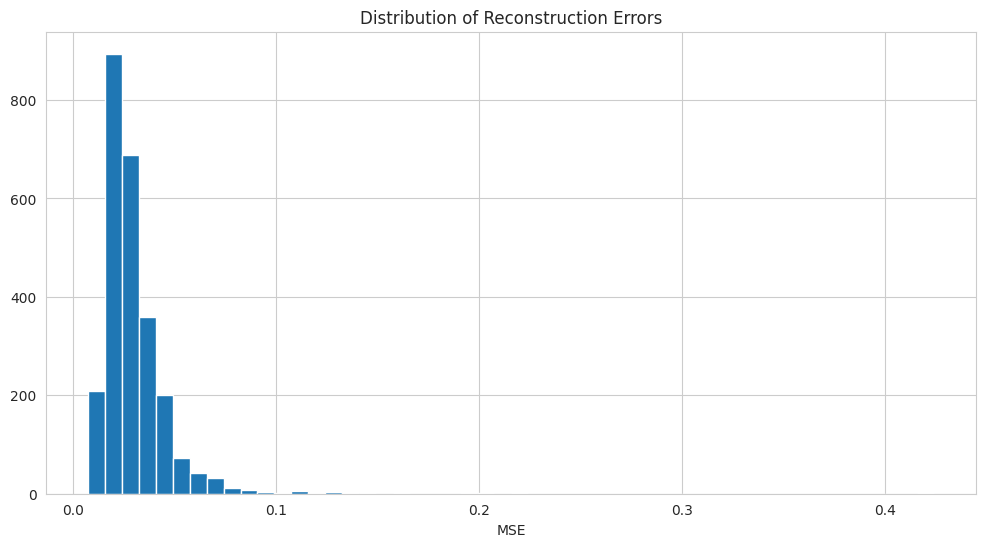

Anomaly threshold at 95th percentile: 0.055864


In [12]:
model.eval()
recon_errors = []

with torch.no_grad():
    for seg in data_norm:
        x = torch.tensor(seg, dtype=torch.float32)
        recon = model(x)
        mse = torch.mean((recon - x) ** 2).item()
        recon_errors.append(mse)

recon_errors = np.array(recon_errors)
plt.hist(recon_errors, bins=50)
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("MSE")
plt.show()

threshold = np.percentile(recon_errors, 95)
print(f"Anomaly threshold at 95th percentile: {threshold:.6f}")

Potential anomalies detected: 127


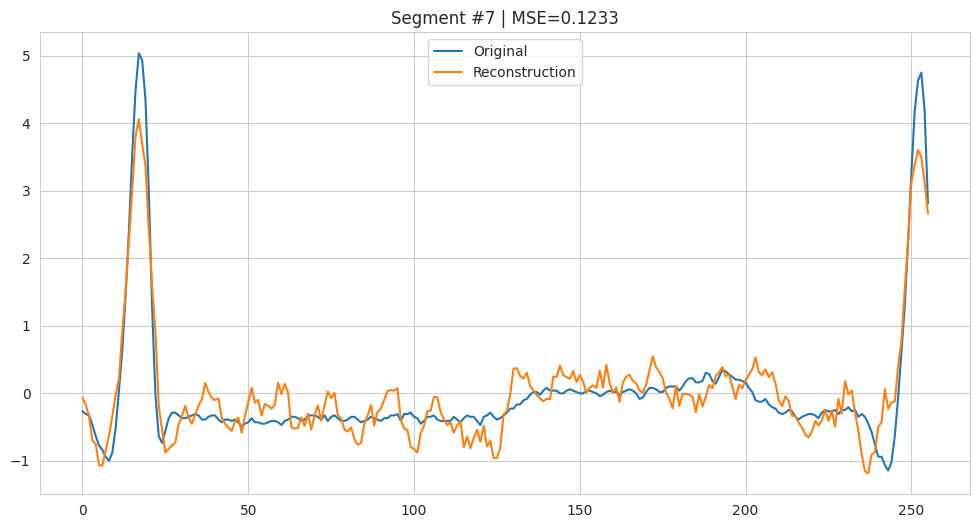

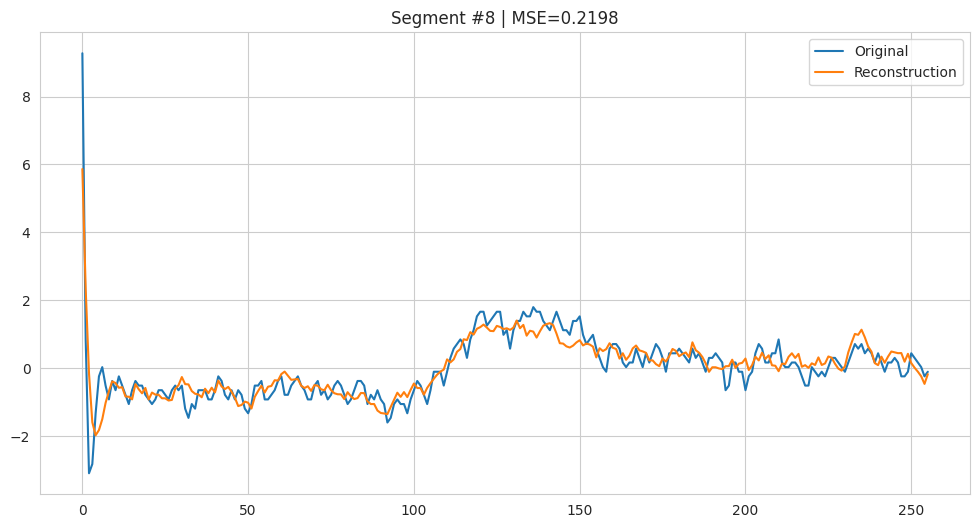

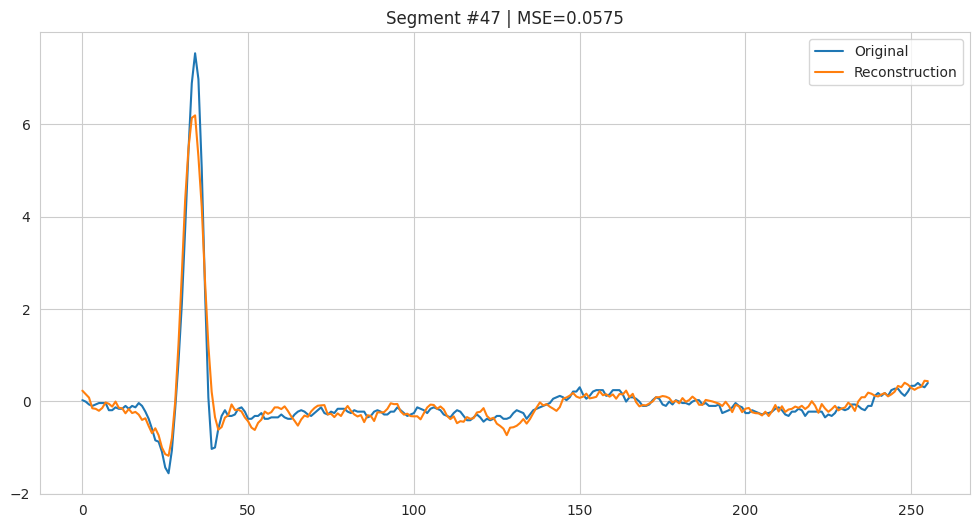

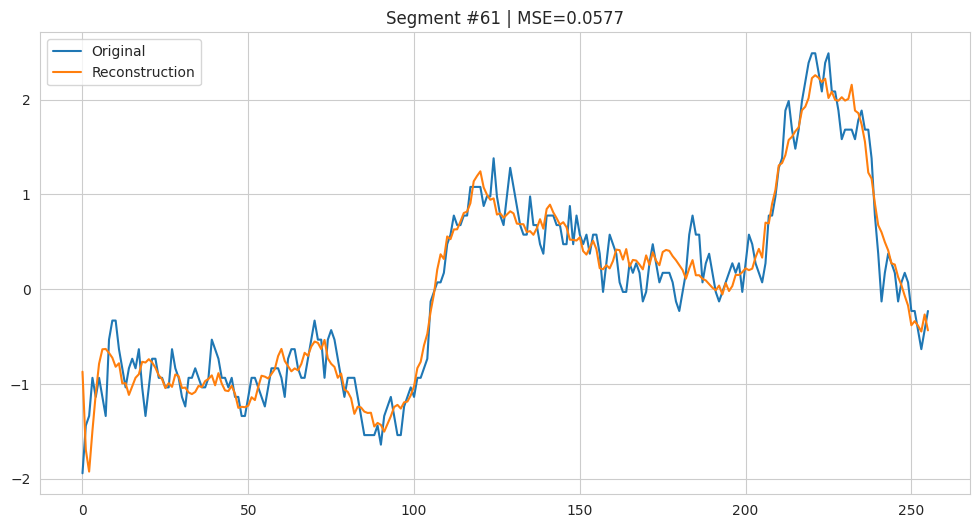

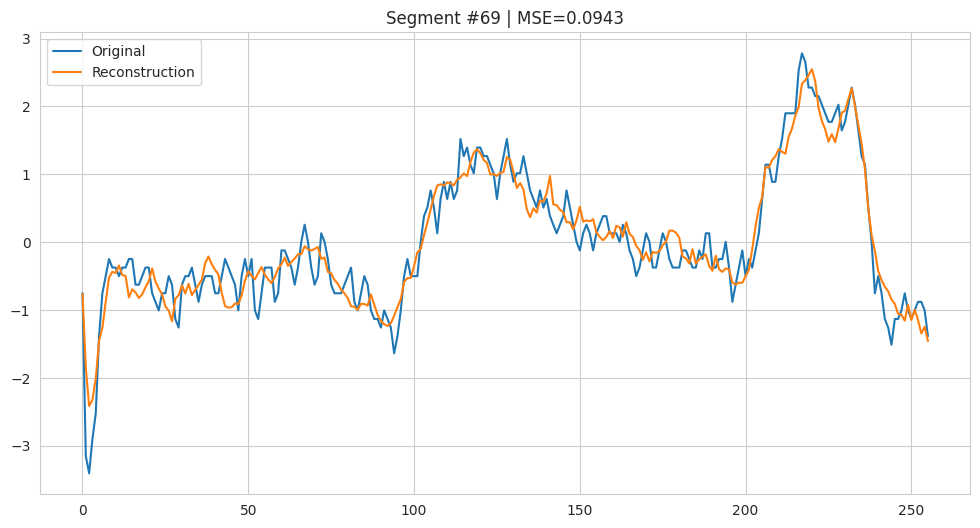

In [13]:
anomaly_indices = np.where(recon_errors > threshold)[0]
print(f"Potential anomalies detected: {len(anomaly_indices)}")

for idx in anomaly_indices[:5]:
    orig = data_norm[idx]
    recon = model(torch.tensor(orig, dtype=torch.float32)).detach().numpy()

    plt.plot(orig, label='Original')
    plt.plot(recon, label='Reconstruction')
    plt.title(f"Segment #{idx} | MSE={recon_errors[idx]:.4f}")
    plt.legend()
    plt.show()

In [14]:
error_df = pd.DataFrame({
    'segment_idx': np.arange(len(recon_errors)),
    'recon_error': recon_errors
})
error_df['anomaly'] = (error_df['recon_error'] > threshold).astype(int)

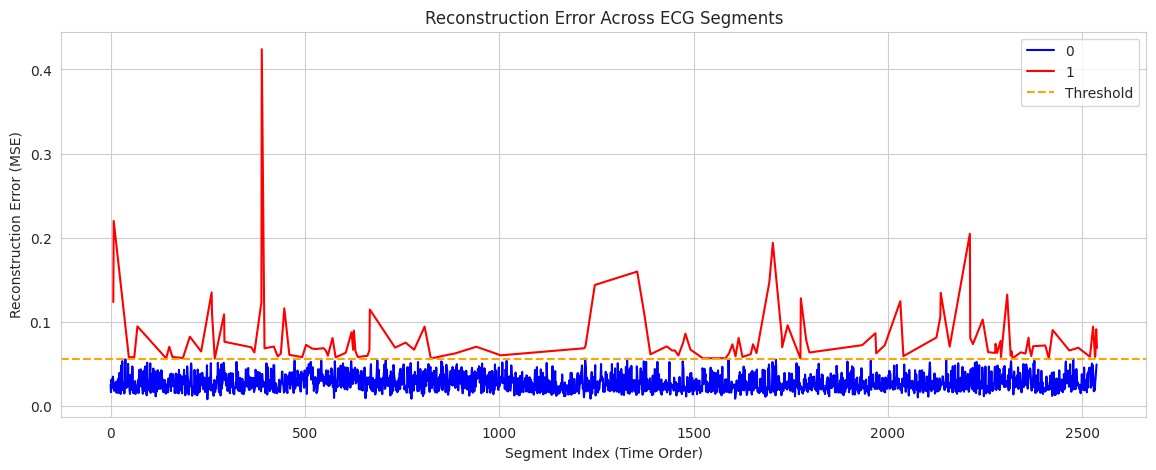

In [15]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=error_df, x='segment_idx', y='recon_error', hue='anomaly', palette=['blue', 'red'])
plt.axhline(threshold, color='orange', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Across ECG Segments")
plt.xlabel("Segment Index (Time Order)")
plt.ylabel("Reconstruction Error (MSE)")
plt.legend()
plt.show()

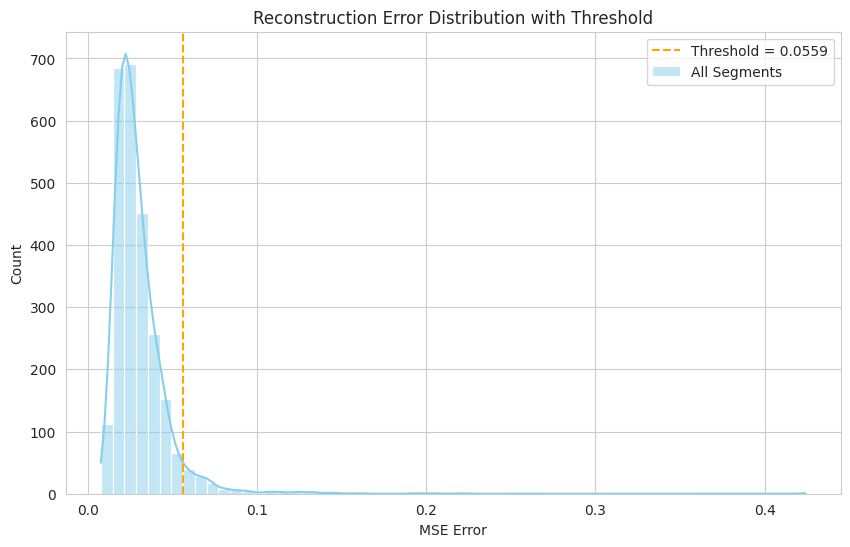

In [22]:
plt.figure(figsize=(10,6))
sns.histplot(recon_errors, bins=60, kde=True, color='skyblue', label="All Segments")
plt.axvline(threshold, color='orange', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.title("Reconstruction Error Distribution with Threshold")
plt.xlabel("MSE Error")
plt.ylabel("Count")
plt.legend()
plt.show()

In [21]:
print("Reconstruction Error Summary:")
print(pd.Series(recon_errors).describe())
print(f"\nThreshold: {threshold:.5f}")
print(f"Segments above threshold (Anomalies): {len(anomaly_indices)} / {len(recon_errors)}")

Reconstruction Error Summary:
count    2539.000000
mean        0.029880
std         0.017831
min         0.007595
25%         0.020064
50%         0.026033
75%         0.034629
max         0.424103
dtype: float64

Threshold: 0.05586
Segments above threshold (Anomalies): 127 / 2539
